In [15]:
import seaborn as sns
import multiprocessing as mp
import pandas as pd
import tqdm
import time
import copy
import numpy as np
#import MySQLdb
import os
import pickle
import warnings
import matplotlib.pyplot as plt

import pickle
def save_variable(v,filename):
    f=open(filename,'wb')          #打开或创建名叫filename的文档。
    pickle.dump(v,f)               #在文件filename中写入v
    f.close()                      #关闭文件，释放内存。
    return filename

def load_variable(filename):
    try:
        f=open(filename,'rb')
        r=pickle.load(f)
        f.close()
        return r
    except EOFError:
        return ""

pickle_path='/Users/jason/JC/公告数据/'


In [9]:
path = '/Users/jason/Desktop/公告类数据/'
signal_df = load_variable(path+'signal_df')

In [11]:
twap_ret = load_variable(path+'theoretical_rtn_metric')
twap_open = load_variable(path+'TwapBegin60')
twap_close = load_variable(path+'TwapClose60')
trade_vol_b120 = load_variable(path+'TradeVolumeBegin120')
trade_vol_c60 = load_variable(path+'TradeVolumeClose60')
vwap_b60 = load_variable(path+'VwapBegin120')
vwap_c60 = load_variable(path+'VwapClose60')

In [17]:
'''twap_open = pd.read_excel(path+'TW开盘价.xlsx')
open_price = pd.read_excel(path+'开盘价.xlsx')
close_price = pd.read_excel(path+'收盘价.xlsx')
market_value = pd.read_excel(path+'市值.xlsx')
vwap = pd.read_excel(path+'VWAP.xlsx')'''
1

1

In [21]:
def treat_downloads(df):
    df.index = [int(i) for i in df.index]
    df.columns = [int(i) for i in df.columns]
    return df

twap_ret = treat_downloads(twap_ret)
twap_open = treat_downloads(twap_open)
twap_close = treat_downloads(twap_close)
trade_vol_b120 = treat_downloads(trade_vol_b120)
trade_vol_c60 = treat_downloads(trade_vol_c60)
vwap_b60 = treat_downloads(vwap_b60)
vwap_c60 = treat_downloads(vwap_c60)

In [22]:
index_need = signal_df.replace(np.nan,0).cumsum(axis=1).replace(0,np.nan).iloc[:,-1].dropna().index
dates_need = signal_df.columns

# MACD

In [25]:
def EMA(array,t):
    EMA=[]
    for i in range(0,len(array)):
        if i+1>=t:
            ema=(2*array.iloc[i,0]+(t-1)*EMA[i-1])/(t+1)
        elif i<=t:
            ema=float(array.iloc[:i+1].mean())
        EMA.append(ema)
    return pd.Series(EMA)

def MACD(df,t1,t2,t3):
    Df=df.copy()
    P=EMA(Df,2)
    EMA1=EMA(Df,t1)
    EMA2=EMA(Df,t2)
    EMA3=EMA(Df,t3)
    #print(Df)
    
    Df['P_EMA1']=list(P/EMA1)
    #Df['P_EMA2']=list(P/EMA2)
    Df['P_EMA3']=list(P/EMA3)
    #Df['EMA1_EMA2']=list(EMA1/EMA2)
    Df['EMA2_EMA3']=list(EMA2/EMA3)
    #print((EMA1-EMA2)/DEA)
    DIFF1=pd.DataFrame(EMA1-EMA3)
    DEA1=EMA(DIFF1,10)
    Df['DIFF_DEA_S']=list((EMA1-EMA3)/DEA1)
    
    DIFF2=pd.DataFrame(EMA1-EMA2)
    DEA2=EMA(DIFF2,10)
    Df['DIFF_DEA_M']=list((EMA1-EMA2)/DEA2)
    
    DIFF3=pd.DataFrame(EMA2-EMA3)
    DEA3=EMA(DIFF3,10)
    Df['DIFF_DEA_L']=list((EMA2-EMA3)/DEA3)
    return Df


In [26]:
close_price = twap_close

In [27]:
t = MACD(pd.DataFrame(close_price.iloc[3,:]),3,10,20)
t.corr()

,4,P_EMA1,P_EMA3,EMA2_EMA3,DIFF_DEA_S,DIFF_DEA_M,DIFF_DEA_L
4,1.000000,0.123821,0.295855,0.316452,-0.028312,-0.013611,-0.000225
P_EMA1,0.123821,1.000000,0.677700,0.321568,0.090645,0.033844,0.102465
P_EMA3,0.295855,0.677700,1.000000,0.892077,0.064093,0.008004,0.052850
EMA2_EMA3,0.316452,0.321568,0.892077,1.000000,0.016138,-0.021014,0.031442
DIFF_DEA_S,-0.028312,0.090645,0.064093,0.016138,1.000000,0.000511,-0.005915
DIFF_DEA_M,-0.013611,0.033844,0.008004,-0.021014,0.000511,1.000000,0.001007
DIFF_DEA_L,-0.000225,0.102465,0.052850,0.031442,-0.005915,0.001007,1.000000


In [28]:
#先将close_price backfill，之后再做这个操作，最后再用原来的mask罩上去即可
close_price_part = (close_price[dates_need].loc[index_need]).fillna(method='ffill',axis=1)
df_mask = close_price_part.isna().replace([True,False],[np.nan,1])
close_price_part = close_price_part.fillna(method='bfill',axis=1)
MACD_dict={}
import tqdm
for i in tqdm.tqdm(range(0,len(index_need))):
    MACD_df = MACD(pd.DataFrame(close_price_part.iloc[i,:]),3,10,20)
    MACD_dict[index_need[i]] = MACD_df  


100%|██████████| 2169/2169 [07:24<00:00,  4.88it/s]


In [29]:
name_list = ['P_EMA1','P_EMA3','EMA2_EMA3','DIFF_DEA_S','DIFF_DEA_M','DIFF_DEA_L']

def to_factor_df(name_list,RSI_dict):
    RSI_res_dict = {}
    for i in name_list :
        RSI_res_dict[i] = close_price_part.copy()

    for j in name_list :
        fac_df = RSI_res_dict[j]
        for i in RSI_dict :
            fac_df.loc[i] = RSI_dict[i][j]
        fac_df = fac_df * df_mask
        RSI_res_dict[j] = fac_df
    
    return RSI_res_dict

MACD_res_dict = to_factor_df(name_list,MACD_dict)


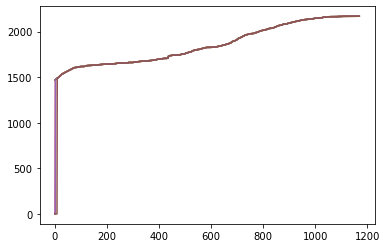

In [30]:
for i in name_list:
    plt.plot(list(MACD_res_dict[i].count()))

In [331]:
MACD_res_dict['DIFF_DEA_S'].corrwith(MACD_res_dict['DIFF_DEA_L']).mean()

0.004151000751596659

# RSI

In [31]:
def RSI(df):
    Df=df.copy()
    Period=[2,10,20]
    RSI3 = []
    for i in range(0,len(Period)):
        t=Period[i]
        array=Df
        U=[0]
        D=[0.1]
        for j in range(1,len(array)):
            if array.iloc[j,0]>array.iloc[j-1,0]:
                U.append(array.iloc[j,0]-array.iloc[j-1,0])
                D.append(0)
            else:
                D.append(array.iloc[j-1,0]-array.iloc[j,0])
                U.append(0)
        US=EMA(pd.DataFrame(U),t)
        DS=EMA(pd.DataFrame(D),t)
        #print(US)
        RS=US/DS
        RSI=(1-1/(1+RS))
        RSI3.append(RSI)
    #print(RSI3[0])
    Df['RSI6']=np.array(RSI3[0])
    #Df['RSI12']=np.array(RSI3[1])
    Df['RSI24']=np.array(RSI3[1])
    #Df['RSI6-12']=np.array(RSI3[0]/RSI3[1])
    Df['RSI6-24']=np.array(RSI3[0]/RSI3[1])
    #Df['RSI12-24']=np.array(RSI3[1]/RSI3[2])
    
    DIFF = RSI3[0] - RSI3[2]
    DEA=EMA(pd.DataFrame(DIFF),10)
    Df['RSI_BAR']=np.array(DIFF/DEA)
    
    DIFF = RSI3[1] - RSI3[2]
    DEA=EMA(pd.DataFrame(DIFF),10)
    Df['RSI_BAR1']=np.array(DIFF/DEA)
    
    DIFF = RSI3[0] - RSI3[1]
    DEA=EMA(pd.DataFrame(DIFF),10)
    Df['RSI_BAR2']=np.array(DIFF/DEA)
    
    return Df

In [32]:
t = RSI(pd.DataFrame(close_price.iloc[3,:]))
t.corr()

,4,RSI6,RSI24,RSI6-24,RSI_BAR,RSI_BAR1,RSI_BAR2
4,1.000000,-0.003895,0.053297,-0.039097,0.014184,-0.031324,0.100624
RSI6,-0.003895,1.000000,0.720395,0.832920,-0.042031,-0.018699,-0.065578
RSI24,0.053297,0.720395,1.000000,0.301488,-0.073368,0.002776,-0.036926
RSI6-24,-0.039097,0.832920,0.301488,1.000000,-0.032090,-0.036442,-0.069994
RSI_BAR,0.014184,-0.042031,-0.073368,-0.032090,1.000000,0.001293,-0.001906
RSI_BAR1,-0.031324,-0.018699,0.002776,-0.036442,0.001293,1.000000,-0.009227
RSI_BAR2,0.100624,-0.065578,-0.036926,-0.069994,-0.001906,-0.009227,1.000000


In [33]:

close_price_part = (close_price[dates_need].loc[index_need]).fillna(method='ffill',axis=1)
df_mask = close_price_part.isna().replace([True,False],[np.nan,1])
close_price_part = close_price_part.fillna(method='bfill',axis=1)
RSI_dict={}
import tqdm
for i in tqdm.tqdm(range(0,len(index_need))):
    RSI_df = RSI(pd.DataFrame(close_price_part.iloc[i,:]))
    RSI_dict[index_need[i]] = RSI_df    


100%|██████████| 2169/2169 [19:10<00:00,  1.89it/s]


In [34]:
def to_factor_df(name_list,RSI_dict):
    RSI_res_dict = {}
    for i in name_list :
        RSI_res_dict[i] = close_price_part.copy()

    for j in name_list :
        fac_df = RSI_res_dict[j]
        for i in RSI_dict :
            fac_df.loc[i] = RSI_dict[i][j]
        fac_df = fac_df * df_mask
        RSI_res_dict[j] = fac_df
    
    return RSI_res_dict

name_list = ['RSI6','RSI24', 'RSI6-24', 'RSI_BAR','RSI_BAR1','RSI_BAR2']
RSI_res_dict = to_factor_df(name_list,RSI_dict)


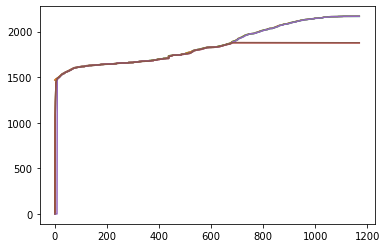

In [35]:
for i in name_list:
    plt.plot(list(RSI_res_dict[i].count()))

# KDJ

In [36]:
def KDJ(Df,t,a):
    array=Df.copy()
    RSV=[]
    for i in range(0,len(array)):
        if i==0:
            rsv=0
        elif i+1>=t:
            Slice=np.array(array.iloc[i+1-t:i+1,0])
            #print(Slice)
            C=Slice[-1]
            L=np.min(Slice)
            H=np.max(Slice)
            rsv=(C-L)/(H-L)
        elif i<=t:
            Slice=np.array(array.iloc[:i+1,0])
            C=Slice[-1]
            L=np.min(Slice)
            H=np.max(Slice)
            rsv=(C-L)/(H-L)
        if np.isnan(rsv):
            rsv = 0
        RSV.append(rsv)
    K=[]
    D=[]
    for i in range(0,len(array)):
        if i==0:
            K.append(RSV[i])
            D.append(RSV[i])
        else:
            k=a*RSV[i]+(1-a)*K[i-1]
            d=a*k+(1-a)*D[i-1]
            K.append(k)
            D.append(d)
    J=np.array(K)-np.array(D)
    K = np.array(K)
    D = np.array(D)
    #array['RSV'] = RSV
    array['K']=list(K)
    array['J']=list(J)
    #array['D']=list(D)
    array['K-D']=list(K/D)
    #array['D-J']=list(D/J)
    array['K-J']=list(K/J)
    
    DEA=EMA(pd.DataFrame(J),10)
    array['KDJ_BAR1']=np.array(J/DEA)
    
    DEA=EMA(pd.DataFrame(J),5)
    array['KDJ_BAR2']=np.array(J/DEA)
    
    return array

In [37]:
t = KDJ(pd.DataFrame(close_price.iloc[3,:]),10,1/3)
t.corr()

<ipython-input-36-99d768c95a43>:41: RuntimeWarning: invalid value encountered in true_divide
  array['K-D']=list(K/D)
<ipython-input-36-99d768c95a43>:43: RuntimeWarning: invalid value encountered in true_divide
  array['K-J']=list(K/J)


,4,K,J,K-D,K-J,KDJ_BAR1,KDJ_BAR2
4,1.000000,0.232898,-0.014823,0.005147,0.010496,0.006890,-0.039731
K,0.232898,1.000000,0.420826,0.569710,0.025627,0.020508,0.019801
J,-0.014823,0.420826,1.000000,0.642046,0.024927,-0.006933,-0.040273
K-D,0.005147,0.569710,0.642046,1.000000,0.026800,-0.021457,-0.022558
K-J,0.010496,0.025627,0.024927,0.026800,1.000000,0.000335,-0.003045
KDJ_BAR1,0.006890,0.020508,-0.006933,-0.021457,0.000335,1.000000,0.007560
KDJ_BAR2,-0.039731,0.019801,-0.040273,-0.022558,-0.003045,0.007560,1.000000


In [38]:
t = KDJ(pd.DataFrame(close_price.iloc[3,:]),5,1/3)

close_price_part = (close_price[dates_need].loc[index_need]).fillna(method='ffill',axis=1)
df_mask = close_price_part.isna().replace([True,False],[np.nan,1])
close_price_part = close_price_part.fillna(method='bfill',axis=1)
KDJ_dict={}
import tqdm
for i in tqdm.tqdm(range(0,len(index_need))):
    KDJ_df = KDJ(pd.DataFrame(close_price_part.iloc[i,:]),5,1/3)
    KDJ_dict[index_need[i]] = KDJ_df  
    
name_list = ['K','J','K-D','K-J','KDJ_BAR1','KDJ_BAR2']
KDJ_res_dict = to_factor_df(name_list,KDJ_dict)


<ipython-input-36-99d768c95a43>:41: RuntimeWarning: invalid value encountered in true_divide
  array['K-D']=list(K/D)
<ipython-input-36-99d768c95a43>:43: RuntimeWarning: invalid value encountered in true_divide
  array['K-J']=list(K/J)
  0%|          | 2/2169 [00:00<06:36,  5.47it/s]<ipython-input-36-99d768c95a43>:13: RuntimeWarning: invalid value encountered in double_scalars
  rsv=(C-L)/(H-L)
<ipython-input-36-99d768c95a43>:43: RuntimeWarning: divide by zero encountered in true_divide
  array['K-J']=list(K/J)
  0%|          | 6/2169 [00:01<06:35,  5.47it/s]<ipython-input-36-99d768c95a43>:19: RuntimeWarning: invalid value encountered in double_scalars
  rsv=(C-L)/(H-L)
100%|██████████| 2169/2169 [06:36<00:00,  5.47it/s]


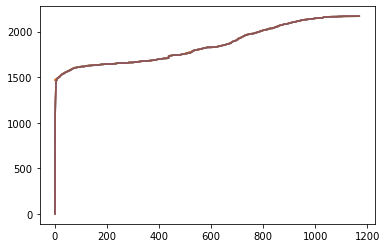

In [39]:
for i in name_list:
    plt.plot(list(KDJ_res_dict[i].count()))

# 支撑阻力——布林带

In [40]:
def Boll(Df,t,k):
    array=Df.copy()
    price = np.array(array.iloc[:,0])
    Up=[]
    Mid=[]
    Down=[]
    for i in range(0,len(array)):
        if i==0:
            ma=array.iloc[i,0]
            std=0
        elif i+1>=t:
            Slice=array.iloc[i+1-t:i+1,0]
            ma=Slice.mean()
            std=Slice.std()
        elif i<=t:
            Slice=array.iloc[:i+1,0]
            ma=Slice.mean()
            std=Slice.std()
        Up.append(ma+k*std)
        Mid.append(ma)
        Down.append(ma-k*std)
    Up = np.array(Up)
    Down = np.array(Down)
    Mid = np.array(Mid)
    Df['Boll(U/P)']=list(Up/price)
    #Df['Boll(M/P)']=list(Mid/price)
    Df['Boll(D/P)']=list(Down/price)
    Df['Boll(U/D)']=list(Up/Down)
    Wid = Up-Down
    Df['Boll(W20)']=list(Wid/EMA(pd.DataFrame(Wid),20))
    #Df['Boll(W10)']=list(Wid/EMA(pd.DataFrame(Wid),6))
    Df['Boll(W3)']=list(Wid/EMA(pd.DataFrame(Wid),3))
    Df['Boll(MW)']=list(Mid/Wid)
    return Df


In [41]:
t = Boll(pd.DataFrame(close_price.iloc[3,:]),10,1)
t.corr()

<ipython-input-40-cfe337cc15ae>:33: RuntimeWarning: divide by zero encountered in true_divide
  Df['Boll(MW)']=list(Mid/Wid)


,4,Boll(U/P),Boll(D/P),Boll(U/D),Boll(W20),Boll(W3),Boll(MW)
4,1.000000,-0.065723,-0.266339,0.234225,0.066399,-0.011080,-0.050053
Boll(U/P),-0.065723,1.000000,0.644345,0.415213,0.072508,0.010249,-0.059420
Boll(D/P),-0.266339,0.644345,1.000000,-0.418131,-0.293051,-0.154663,0.055381
Boll(U/D),0.234225,0.415213,-0.418131,1.000000,0.432313,0.182552,-0.130720
Boll(W20),0.066399,0.072508,-0.293051,0.432313,1.000000,0.670208,-0.448281
Boll(W3),-0.011080,0.010249,-0.154663,0.182552,0.670208,1.000000,-0.282439
Boll(MW),-0.050053,-0.059420,0.055381,-0.130720,-0.448281,-0.282439,1.000000


In [42]:
close_price_part = (close_price[dates_need].loc[index_need]).fillna(method='ffill',axis=1)
df_mask = close_price_part.isna().replace([True,False],[np.nan,1])
close_price_part = close_price_part.fillna(method='bfill',axis=1)
Boll_dict={}
import tqdm
for i in tqdm.tqdm(range(0,len(index_need))):
    Boll_df = Boll(pd.DataFrame(close_price_part.iloc[i,:]),10,1)
    Boll_dict[index_need[i]] = Boll_df  
    



  0%|          | 0/2169 [00:00<?, ?it/s]<ipython-input-40-cfe337cc15ae>:33: RuntimeWarning: divide by zero encountered in true_divide
  Df['Boll(MW)']=list(Mid/Wid)
100%|██████████| 2169/2169 [08:10<00:00,  4.42it/s]


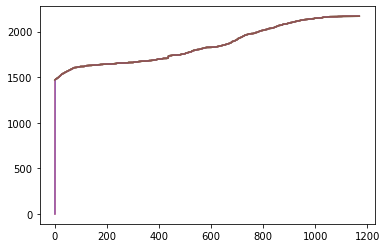

In [43]:
name_list = ['Boll(U/P)', 'Boll(D/P)', 'Boll(U/D)', 'Boll(W20)',
       'Boll(W3)','Boll(MW)']
Boll_res_dict = to_factor_df(name_list,Boll_dict)
for i in name_list:
    plt.plot(list(Boll_res_dict[i].count()))

# 波动率

In [44]:
factor_cha_std1 = twap_ret.rolling(window=5,axis=1).std()
factor_cha_std2 = twap_ret.rolling(window=20,axis=1).std()
factor_cha_skew1 = twap_ret.rolling(window=5,axis=1).skew()
factor_cha_skew2 = twap_ret.rolling(window=20,axis=1).skew()
factor_cha_kurt1 = twap_ret.rolling(window=5,axis=1).kurt()
factor_cha_kurt2 = twap_ret.rolling(window=20,axis=1).kurt()


/Users/jason/opt/anaconda3/lib/python3.8/site-packages/pandas/core/window/rolling.py:455: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods)


In [45]:
vol_name = ['factor_cha_std1','factor_cha_std2','factor_cha_skew1','factor_cha_skew2','factor_cha_kurt1','factor_cha_kurt2']
Vol_res_dict = {i:eval(i)[dates_need].loc[index_need] for i in vol_name}


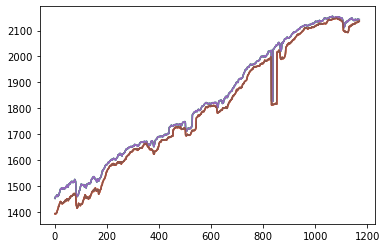

In [46]:
for i in vol_name:
    plt.plot(list(Vol_res_dict[i].count()))

# 收益率特征工程

In [47]:
factor_cha_diff1 = twap_ret.shift(1,axis=1).diff(1,axis=1)
factor_cha_diff2 = twap_ret.shift(1,axis=1).diff(5,axis=1)
factor_cha_diff3 = twap_ret.shift(1,axis=1).diff(20,axis=1)
factor_cha_lag1 = twap_ret.shift(1,axis=1)
factor_cha_lag2 = twap_ret.shift(5,axis=1)
factor_cha_lag3 = twap_ret.shift(20,axis=1)

In [48]:
ret_name = ['factor_cha_diff1','factor_cha_diff2','factor_cha_diff3','factor_cha_lag1','factor_cha_lag2','factor_cha_lag3']
ret_res_dict = {i:eval(i)[dates_need].loc[index_need] for i in ret_name}


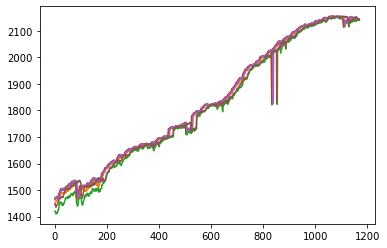

In [49]:
for i in ret_name:
    plt.plot(list(ret_res_dict[i].count()))

# 交易量因子

In [51]:
factor_tv = trade_vol_b120
factor_tv_vc = vwap_b60/close_price
factor_tv_ma1 = trade_vol_b120/(trade_vol_b120.rolling(window=20,axis=1).mean())
factor_tv_ma2 = trade_vol_c60/(trade_vol_c60.rolling(window=20,axis=1).mean())
factor_tv_ma3 = trade_vol_b120/(trade_vol_b120.rolling(window=3,axis=1).mean())
cm = close_price/close_price.rolling(window=5,axis=1).mean()
factor_tv_pt = cm / factor_tv_ma2

In [52]:
tv_name = ['factor_tv','factor_tv_vc','factor_tv_ma1','factor_tv_ma2','factor_tv_ma3','factor_tv_pt']
tv_res_dict = {i:eval(i)[dates_need].loc[index_need] for i in tv_name}

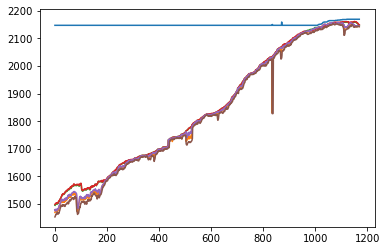

In [53]:
for i in tv_name:
    plt.plot(list(tv_res_dict[i].count()))

In [57]:
dict_all = [MACD_res_dict,RSI_res_dict,KDJ_res_dict,Boll_res_dict,Vol_res_dict,ret_res_dict,tv_res_dict]

In [58]:
Factor_total_dict = {}
category = ['MACD','RSI','KDJ','Boll','VOL','CHA','TRD']
for i in range(0,len(dict_all)):
    for j in range(0,len(dict_all[i].keys())):
        name = category[i]+'_'+str(int(j))
        df = dict_all[i][list(dict_all[i].keys())[j]]
        Factor_total_dict[name] = df

# 因子相关性分析

In [59]:
corr_mat = np.zeros([len(Factor_total_dict),len(Factor_total_dict)])
names = list(Factor_total_dict.keys())
import tqdm
for i in tqdm.tqdm(range(0,len(Factor_total_dict))):
    for j in range(i,len(Factor_total_dict)):
        corr = Factor_total_dict[names[i]].corrwith(Factor_total_dict[names[j]]).mean()
        corr_mat[i][j] = corr
        corr_mat[j][i] = corr

100%|██████████| 42/42 [01:25<00:00,  2.04s/it]


In [60]:
corr_mat = pd.DataFrame(corr_mat,index = Factor_total_dict.keys(),columns = Factor_total_dict.keys())

In [79]:
corr_mat.columns
names_list = ['MACD_1', 'MACD_2', 'MACD_3', 'MACD_4', 'MACD_5', 'MACD_6', 
       'RSI_1', 'RSI_2', 'RSI_3', 'RSI_4', 'RSI_5', 'RSI_6', 'KDJ_1', 'KDJ_2',
       'KDJ_3', 'KDJ_4', 'KDJ_5','KDJ_6', 'Boll_1', 'Boll_2', 'Boll_3',
       'Boll_4', 'Boll_5', 'Boll_6',  'Mom_1', 'Mom_2', 'Mom_3', 'Mom_4',
       'Mom_5', 'Mom_6','Ret_1', 'Ret_2', 'Ret_3', 'Ret_4', 'Ret_5','Ret_6', 
       'Trd_1', 'Trd_2', 'Trd_3', 'Trd_4', 'Trd_5' ,'Trd_6']
corr_mat.index = names_list
corr_mat.columns = names_list

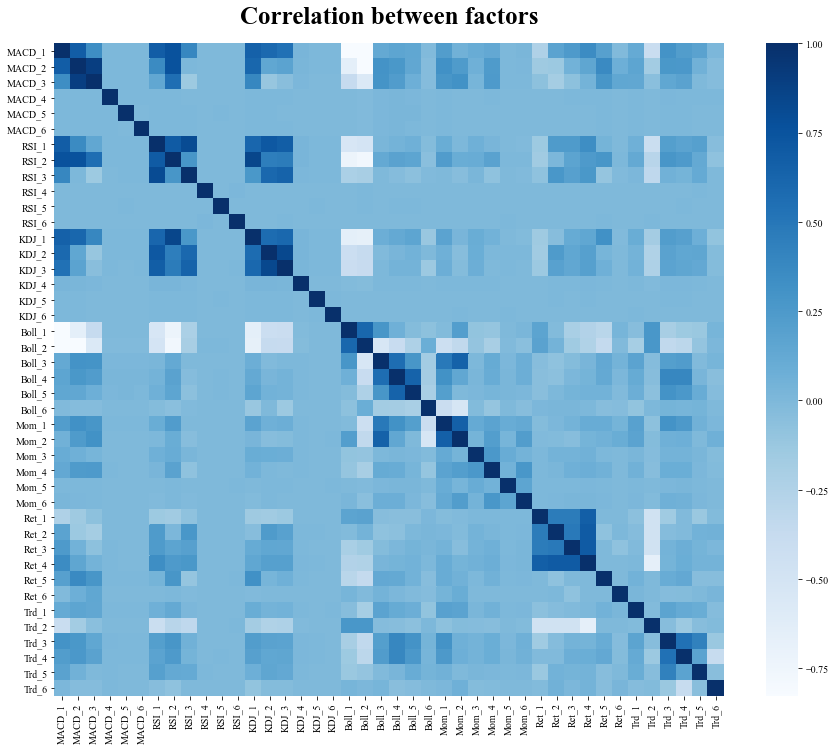

In [107]:
import seaborn as sns
plt.figure(figsize=(15,12))
plt.rcParams['font.family'] = 'Times New Roman' #设置字体
sns.heatmap(corr_mat,cmap='Blues')
plt.title('Correlation between factors',fontproperties='Times New Roman',fontsize=30,pad=20,fontweight=600)
plt.savefig('/Users/jason/JC/公告数据/Figures/Corr_df.jpg',dpi=300)

In [64]:
Y = twap_ret.loc[index_need][dates_need]
def pre_process(a):
    a = a.replace([np.inf,-np.inf],[np.nan,np.nan])
    a = (a - a.min())/(a.max() - a.min())-0.5
    if a.corrwith(Y).mean() <= 0:
        a = -a
    return a

In [65]:
Factor_total_dict = {i:pre_process(Factor_total_dict[i]) for i in Factor_total_dict.keys()}

In [89]:
Y = twap_ret.loc[index_need][dates_need]
Factor_IC_dict = {i:Factor_total_dict[i].corrwith(Y) for i in Factor_total_dict.keys()}

Factor_IC_df = pd.DataFrame(Factor_IC_dict).reset_index().drop(columns = 'index')
name = Factor_IC_df.mean().sort_values().index
character = []
for i in Factor_IC_df.mean().sort_values().index:
    character.append(i[:3])
    
Colors = ['brown', 'orange', 'gold','lime','aqua','royalblue','violet']
col_map = pd.DataFrame(Colors,pd.Series(character).unique(),columns = ['Col'])
color_list = pd.DataFrame(character,columns = ['Cha']).merge(col_map,left_on = 'Cha',right_index = True,how = 'left')['Col']


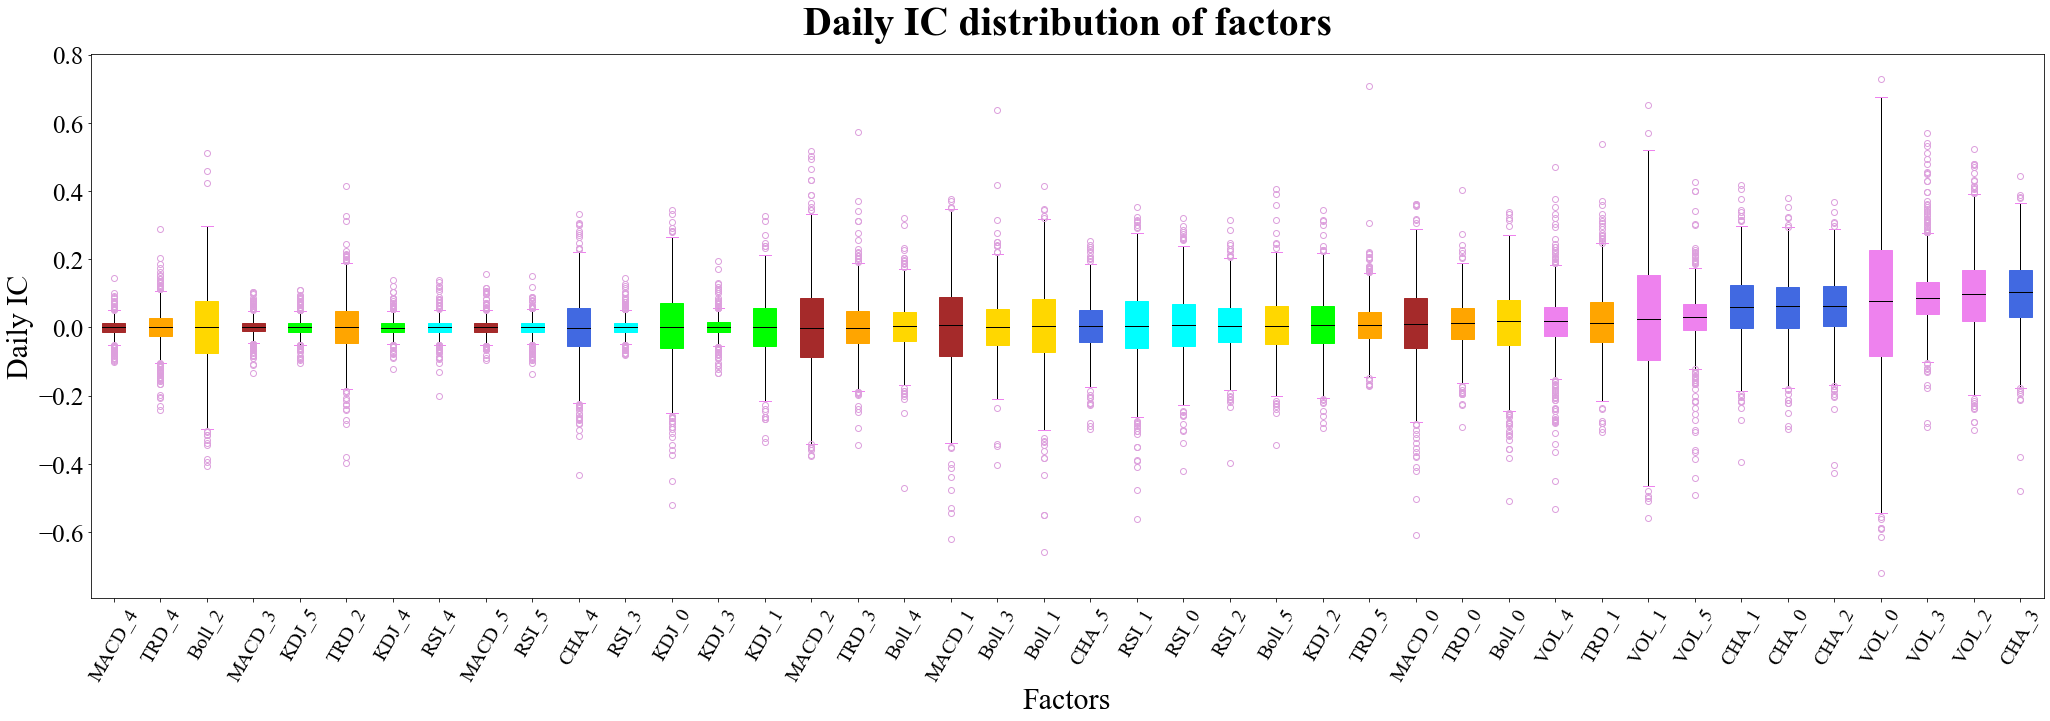

In [109]:
plt.figure(figsize=(35,10))
Alt = Factor_IC_df.dropna()[name]
c=['black','black','plum','plum','violet']
f= plt.boxplot(Alt,patch_artist=True,
               whiskerprops=dict(color=c[0]),medianprops=dict(color=c[1]),
              flierprops=dict(color=c[2], markeredgecolor=c[3]),capprops=dict(color=c[4]))
for box, c in zip(f['boxes'], color_list):
    box.set(color=c)
plt.xticks(np.arange(1,len(Alt.columns)+1),Alt.columns,fontsize=20,rotation=60)
plt.yticks(fontsize=25)
    #box.set(facecolor=c)
plt.ylabel('Daily IC',fontsize=30)
plt.xlabel('Factors',fontsize=30)
plt.title('Daily IC distribution of factors',fontproperties='Times New Roman',fontsize=40,pad=20,fontweight=600)
plt.savefig('/Users/jason/JC/公告数据/Figures/Fac_IC.jpg',dpi=300)
plt.show()


# 保存：Factors

In [75]:
save_variable(Factor_total_dict,pickle_path+'Factors')

'/Users/jason/JC/公告数据/Factors'

In [15]:
ret_res_dict.keys()

dict_keys(['factor_cha_diff1', 'factor_cha_diff2', 'factor_cha_diff3', 'factor_cha_lag1', 'factor_cha_lag2', 'factor_cha_lag3'])

In [11]:
Factor_data_dict = load_variable('/Users/jason/JC/公告数据/Factors')